# Helper methods for InputVar

This tutorial complements the general tutorial on the uncertainty and sensitivity analysis module [unsequa](climada_engine_unsequa.ipynb).

The InputVar class provides a few helper methods to generate generic uncertainty input variables for exposures, impact function sets, hazards, and entities (including measures cost and disc rates).

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Helper-methods-for-InputVar" data-toc-modified-id="Helper-methods-for-InputVar-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Helper methods for InputVar</a></span><ul class="toc-item"><li><span><a href="#Exposures" data-toc-modified-id="Exposures-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Exposures</a></span><ul class="toc-item"><li><span><a href="#Example:-single-exposures" data-toc-modified-id="Example:-single-exposures-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Example: single exposures</a></span></li><li><span><a href="#Example:-list-of-litpop-exposures-with-different-exponents" data-toc-modified-id="Example:-list-of-litpop-exposures-with-different-exponents-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Example: list of litpop exposures with different exponents</a></span></li></ul></li><li><span><a href="#Hazard" data-toc-modified-id="Hazard-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Hazard</a></span></li><li><span><a href="#ImpactFuncSet" data-toc-modified-id="ImpactFuncSet-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>ImpactFuncSet</a></span></li><li><span><a href="#Entity" data-toc-modified-id="Entity-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Entity</a></span><ul class="toc-item"><li><span><a href="#Example:-single-exposures" data-toc-modified-id="Example:-single-exposures-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Example: single exposures</a></span></li><li><span><a href="#Example:-list-of-Litpop-exposures-with-different-exponents" data-toc-modified-id="Example:-list-of-Litpop-exposures-with-different-exponents-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Example: list of Litpop exposures with different exponents</a></span></li></ul></li><li><span><a href="#Entity-Future" data-toc-modified-id="Entity-Future-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Entity Future</a></span><ul class="toc-item"><li><span><a href="#Example:-single-exposures" data-toc-modified-id="Example:-single-exposures-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Example: single exposures</a></span></li><li><span><a href="#Example:-list-of-exposures" data-toc-modified-id="Example:-list-of-exposures-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Example: list of exposures</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import warnings
warnings.filterwarnings('ignore') #Ignore warnings for making the tutorial's pdf. 

## Exposures

The following types of uncertainties can be added:

- ET: scale the total value (homogeneously)
        The value at each exposure point is multiplied by a number
        sampled uniformly from a distribution with
        (min, max) = bounds_totvalue
- EN: mutliplicative noise (inhomogeneous)
        The value of each exposure point is independently multiplied by
        a random number sampled uniformly from a distribution
        with (min, max) = bounds_noise. EN is the value of the seed
        for  the uniform random number generator.
- EL: sample uniformly from exposure list
        From the provided list of exposure is elements are uniformly
        sampled. For example, LitPop instances with different exponents.


If a bounds is None, this parameter is assumed to have no uncertainty.

### Example: single exposures 

In [2]:
#Define the base exposure
from climada.util.constants import EXP_DEMO_H5
from climada.entity import Exposures
exp_base = Exposures.from_hdf5(EXP_DEMO_H5)

2022-01-10 21:10:32,810 - climada.entity.exposures.base - INFO - Reading /Users/ckropf/climada/demo/data/exp_demo_today.h5


In [3]:
from climada.engine.unsequa import InputVar
bounds_totval = [0.9, 1.1] #+- 10% noise on the total exposures value
bounds_noise = [0.9, 1.2] #-10% - +20% noise each exposures point
exp_iv = InputVar.exp([exp_base], bounds_totval, bounds_noise)

In [4]:
#The difference in total value between the base exposure and the average input uncertainty exposure 
#due to the random noise on each exposures point (the average change in the total value is 1.0).
avg_exp = exp_iv.evaluate()
(sum(avg_exp.gdf['value']) - sum(exp_base.gdf['value'])) / sum(exp_base.gdf['value'])

0.03700231587024304

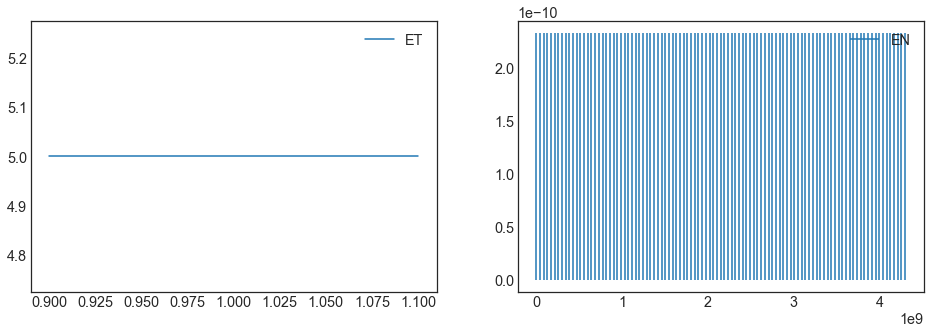

In [5]:
#The values for EN are seeds for the random number generator for the noise sampling and
#thus are uniformly sampled numbers between (0, 2**32-1) 
exp_iv.plot();

### Example: list of litpop exposures with different exponents

In [6]:
#Define a generic method to make litpop instances with different exponent pairs.
from climada.entity import LitPop
def generate_litpop_base(impf_id, value_unit, haz, assign_centr_kwargs,
                          choice_mn, **litpop_kwargs):
    #In-function imports needed only for parallel computing on Windows
    from climada.entity import LitPop
    litpop_base = []
    for [m, n] in choice_mn:
        print('\n Computing litpop for m=%d, n=%d \n' %(m, n))
        litpop_kwargs['exponents'] = (m, n)
        exp = LitPop.from_countries(**litpop_kwargs)
        exp.gdf['impf_' + haz.tag.haz_type] = impf_id
        exp.gdf.drop('impf_', axis=1, inplace=True)
        if value_unit is not None:
            exp.value_unit = value_unit
        exp.assign_centroids(haz, **assign_centr_kwargs)
        litpop_base.append(exp)
    return litpop_base

In [7]:
#Define the parameters of the LitPop instances
tot_pop = 11.317e6
impf_id = 1
value_unit = 'people'
litpop_kwargs = {
    'countries' : ['CUB'],
    'res_arcsec' : 300, 
    'reference_year' : 2020,
    'fin_mode' : 'norm',
    'total_values' : [tot_pop]
}
assign_centr_kwargs={}

# The hazard is needed to assign centroids
from climada.util.constants import HAZ_DEMO_H5
from climada.hazard import Hazard
haz = Hazard.from_hdf5(HAZ_DEMO_H5)

2022-01-10 21:10:33,708 - climada.hazard.base - INFO - Reading /Users/ckropf/climada/demo/data/tc_fl_1990_2004.h5


In [8]:
#Generate the LitPop list

choice_mn = [[0, 0.5], [0, 1], [0, 2]] #Choice of exponents m,n

litpop_list = generate_litpop_base(impf_id, value_unit, haz, assign_centr_kwargs, choice_mn, **litpop_kwargs)



 Computing litpop for m=0, n=0 

2022-01-10 21:10:33,998 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: CUB (192)...

2022-01-10 21:10:33,999 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2022-01-10 21:10:35,544 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2022-01-10 21:10:35,545 - climada.entity.exposures.base - INFO - category_id not set.
2022-01-10 21:10:35,545 - climada.entity.exposures.base - INFO - cover not set.
2022-01-10 21:10:35,546 - climada.entity.exposures.base - INFO - deductible not set.
2022-01-10 21:10:35,546 - climada.entity.exposures.base - INFO - centr_ not set.
2022-01-10 21:10:35,549 - climada.entity.exposures.base - INFO - Matching 1388 exposures with 2500 centroids.
2022-01-10 21:10:35,551 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2022-01-10 21:10:35,577 - climada.uti

In [9]:
from climada.engine.unsequa import InputVar
bounds_totval = [0.9, 1.1] #+- 10% noise on the total exposures value
litpop_iv = InputVar.exp(exp_list = litpop_list,
                         bounds_totval=bounds_totval)

In [10]:
# To choose n=0.5, we have to set EL=1 (the index of 0.5 in choice_n = [0, 0.5, 1, 2])
pop_half = litpop_iv.evaluate(ET=1, EL=1)

In [11]:
pop_half.gdf.tail()

,value,geometry,latitude,longitude,region_id,impf_TC,centr_TC
1383,1713.015083,POINT (-78.29167 22.45833),22.458333,-78.291667,192,1,431
1384,1085.168934,POINT (-79.20833 22.62500),22.625000,-79.208333,192,1,476
1385,950.764517,POINT (-79.62500 22.79167),22.791667,-79.625000,192,1,524
1386,1129.619078,POINT (-79.45833 22.70833),22.708333,-79.458333,192,1,475
1387,300.552289,POINT (-80.79167 23.20833),23.208333,-80.791667,192,1,617


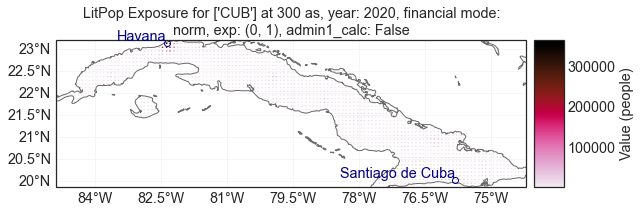

In [12]:
pop_half.plot_hexbin();

In [13]:
# To choose n=1, we have to set EL=2 (the index of 1 in choice_n = [0, 0.5, 1, 2])
pop_one = litpop_iv.evaluate(ET=1, EL=2)

In [14]:
pop_one.gdf.tail()

,value,geometry,latitude,longitude,region_id,impf_TC,centr_TC
1383,56.491498,POINT (-78.29167 22.45833),22.458333,-78.291667,192,1,431
1384,22.670204,POINT (-79.20833 22.62500),22.625000,-79.208333,192,1,476
1385,17.402300,POINT (-79.62500 22.79167),22.791667,-79.625000,192,1,524
1386,24.565452,POINT (-79.45833 22.70833),22.708333,-79.458333,192,1,475
1387,1.739005,POINT (-80.79167 23.20833),23.208333,-80.791667,192,1,617


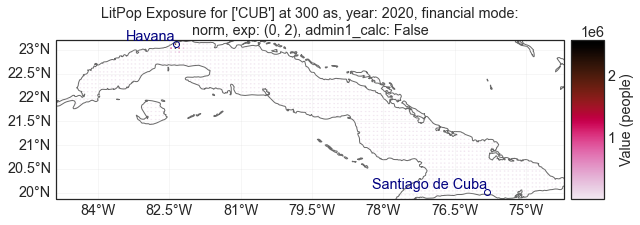

In [15]:
pop_one.plot_hexbin();

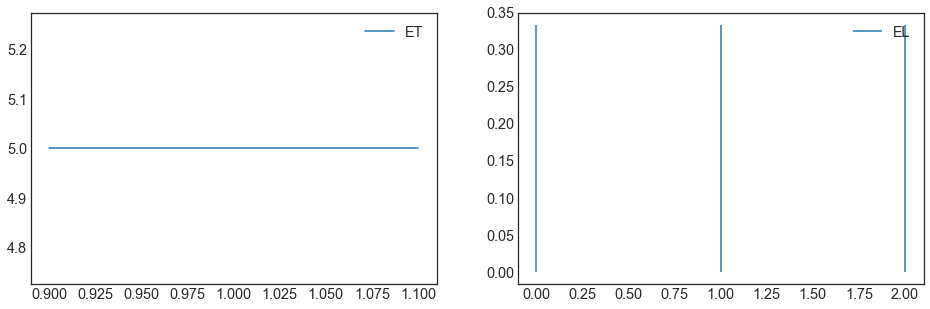

In [16]:
#The values for EN are seeds for the random number generator for the noise sampling and
#thus are uniformly sampled numbers between (0, 2**32-1) 
litpop_iv.plot();

## Hazard

The following types of uncertainties can be added:

- HE: sub-sampling events from the total event set
            For each sub-sample, n_ev events are sampled with replacement. HE is the value of the seed
            for  the uniform random number generator.
- HI: scale the intensity of all events (homogeneously)
            The instensity of all events is multiplied by a number
            sampled uniformly from a distribution with (min, max) = bounds_int
- HF: scale the frequency of all events (homogeneously)
            The frequency of all events is multiplied by a number
            sampled uniformly from a distribution with (min, max) = bounds_freq

If a bounds is None, this parameter is assumed to have no uncertainty.

In [17]:
#Define the base exposure
from climada.util.constants import HAZ_DEMO_H5
from climada.hazard import Hazard
haz_base = Hazard.from_hdf5(HAZ_DEMO_H5)

2022-01-10 21:10:43,742 - climada.hazard.base - INFO - Reading /Users/ckropf/climada/demo/data/tc_fl_1990_2004.h5


In [18]:
from climada.engine.unsequa import InputVar
bounds_freq = [0.9, 1.1] #+- 10% noise on the frequency of all events
bounds_int = None #No uncertainty on the intensity
n_ev = None 
haz_iv = InputVar.haz(haz_base, n_ev=n_ev, bounds_freq=bounds_freq, bounds_int=bounds_int)

In [19]:
#The difference in frequency for HF=1.1 is indeed 10%.
haz_high_freq = haz_iv.evaluate(HE=n_ev, HI=None, HF = 1.1)
(sum(haz_high_freq.frequency) - sum(haz_base.frequency)) / sum(haz_base.frequency)

0.10000000000000736

In [20]:
bounds_freq = [0.9, 1.1] #+- 10% noise on the frequency of all events
bounds_int = None #No uncertainty on the intensity
n_ev = round(0.8 * haz_base.size) #sub-sample with re-draw events to obtain hazards with n=0.8*tot_number_events
haz_iv = InputVar.haz(haz_base, n_ev=n_ev, bounds_freq=bounds_freq, bounds_int=bounds_int)

Note that the HE is not a univariate distribution, but for each sample corresponds to the names of the sub-sampled events. However, to simplify the data stream, the HE is saved as the seed for the random number generator that made the sample. Hence, the value of HE is a label for the given sample. If really needed, the exact chosen events can be obtained as follows.

In [21]:
import numpy as np
HE = 2618981871 #The random seed (number between 0 and 2**32)
rng = np.random.RandomState(int(HE)) #Initialize a random state with the seed
chosen_ev = list(rng.choice(haz_base.event_name, int(n_ev))) #Obtain the corresponding events

In [22]:
#The first event is 
chosen_ev[0]

'1998209N11335'

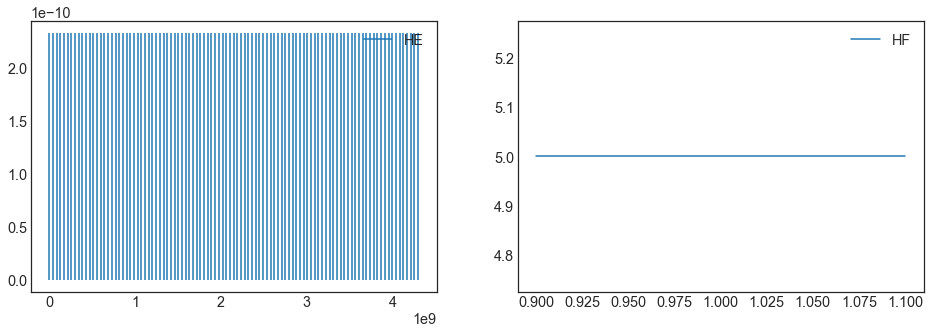

In [23]:
#The values for HE are seeds for the random number generator for the noise sampling and
#thus are uniformly sampled numbers between (0, 2**32-1) 
haz_iv.plot();

The number of events per sub-sample is equal to n_ev

In [24]:
#The number of events per sample is equal to n_ev
haz_sub = haz_iv.evaluate(HE=928165924, HI=None, HF = 1.1)
#The number for HE is irrelevant, as all samples have the same n_Ev
haz_sub.size - n_ev

0

## ImpactFuncSet

The following types of uncertainties can be added:
- MDD: scale the mdd (homogeneously)
            The value of mdd at each intensity is multiplied by a number
            sampled uniformly from a distribution with
            (min, max) = bounds_mdd
- PAA: scale the paa (homogeneously)
            The value of paa at each intensity is multiplied by a number
            sampled uniformly from a distribution with
            (min, max) = bounds_paa
- IFi: shift the intensity (homogeneously)
            The value intensity are all summed with a random number
            sampled uniformly from a distribution with
            (min, max) = bounds_int

If a bounds is None, this parameter is assumed to have no uncertainty.

In [25]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone
impf = ImpfTropCyclone.from_emanuel_usa()
impf_set_base = ImpactFuncSet()
impf_set_base.append(impf)

It is necessary to specify the hazard type and the impact function id. For simplicity, the default uncertainty input variable only looks at the uncertainty on one single impact function.

In [26]:
from climada.engine.unsequa import InputVar
bounds_impfi = [-10, 10] #-10 m/s ; +10m/s uncertainty on the intensity
bounds_mdd = [0.7, 1.1] #-30% - +10% uncertainty on the mdd
bounds_paa = None #No uncertainty in the paa
impf_iv = InputVar.impfset(impf_set_base,
                           bounds_impfi=bounds_impfi,
                           bounds_mdd=bounds_mdd,
                           bounds_paa=bounds_paa,
                           haz_id_dict={'TC': [1]})

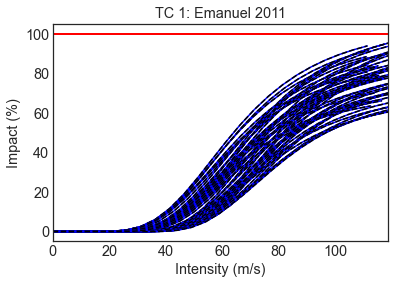

In [27]:
#Plot the impact function for 50 random samples (note for the expert, these are not global)
n = 50
ax = impf_iv.evaluate().plot()
inten = impf_iv.distr_dict['IFi'].rvs(size=n)
mdd = impf_iv.distr_dict['MDD'].rvs(size=n)
for i, m in zip(inten, mdd):
    impf_iv.evaluate(IFi=i, MDD=m).plot(axis=ax)
ax.get_legend().remove()

## Entity


The following types of uncertainties can be added:
- DR: value of constant discount rate (homogeneously)
            The value of the discounts in each year is
            sampled uniformly from a distribution with
            (min, max) = bounds_disc
- CO: scale the cost (homogeneously)
            The cost of all measures is multiplied by the same number
            sampled uniformly from a distribution with
            (min, max) = bounds_cost
- ET: scale the total value (homogeneously)
            The value at each exposure point is multiplied by a number
            sampled uniformly from a distribution with
            (min, max) = bounds_totval
- EN: mutliplicative noise (inhomogeneous)
            The value of each exposure point is independently multiplied by
            a random number sampled uniformly from a distribution
            with (min, max) = bounds_noise. EN is the value of the seed
            for  the uniform random number generator.
- EL: sample uniformly from exposure list
            From the provided list of exposure is elements are uniformly
            sampled. For example, LitPop instances with different exponents.
- MDD: scale the mdd (homogeneously)
            The value of mdd at each intensity is multiplied by a number
            sampled uniformly from a distribution with
            (min, max) = bounds_mdd
- PAA: scale the paa (homogeneously)
            The value of paa at each intensity is multiplied by a number
            sampled uniformly from a distribution with
            (min, max) = bounds_paa
- IFi: shift the intensity (homogeneously)
            The value intensity are all summed with a random number
            sampled uniformly from a distribution with
            (min, max) = bounds_int


If a bounds is None, this parameter is assumed to have no uncertainty.

### Example: single exposures 

In [28]:
from climada.entity import Entity
from climada.util.constants import ENT_DEMO_TODAY
ent = Entity.from_excel(ENT_DEMO_TODAY)
ent.exposures.ref_year = 2018
ent.check()

2022-01-10 21:10:47,184 - climada.entity.exposures.base - INFO - category_id not set.
2022-01-10 21:10:47,185 - climada.entity.exposures.base - INFO - geometry not set.
2022-01-10 21:10:47,185 - climada.entity.exposures.base - INFO - region_id not set.
2022-01-10 21:10:47,185 - climada.entity.exposures.base - INFO - centr_ not set.


In [29]:
from climada.engine.unsequa import InputVar
ent_iv = InputVar.ent(
    impf_set = ent.impact_funcs,
    disc_rate = ent.disc_rates,
    exp_list = [ent.exposures],
    meas_set = ent.measures,
    bounds_disc=[0, 0.08],
    bounds_cost=[0.5, 1.5],
    bounds_totval=[0.9, 1.1],
    bounds_noise=[0.3, 1.9],
    bounds_mdd=[0.9, 1.05],
    bounds_paa=None,
    bounds_impfi=[-2, 5],
    haz_id_dict={'TC': [1]}
    )

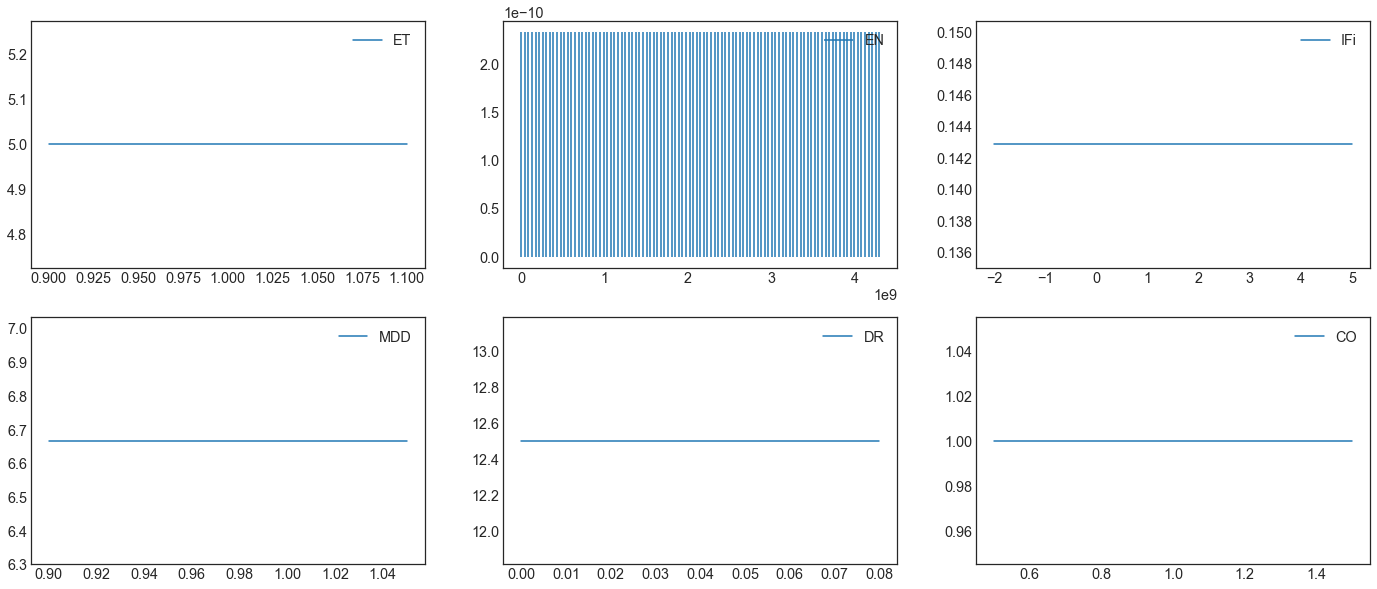

In [30]:
ent_iv.plot();

###  Example: list of Litpop exposures with different exponents

In [31]:
#Define a generic method to make litpop instances with different exponent pairs.
from climada.entity import LitPop
def generate_litpop_base(impf_id, value_unit, haz, assign_centr_kwargs,
                          choice_mn, **litpop_kwargs):
    #In-function imports needed only for parallel computing on Windows
    from climada.entity import LitPop
    litpop_base = []
    for [m, n] in choice_mn:
        print('\n Computing litpop for m=%d, n=%d \n' %(m, n))
        litpop_kwargs['exponents'] = (m, n)
        exp = LitPop.from_countries(**litpop_kwargs)
        exp.gdf['impf_' + haz.tag.haz_type] = impf_id
        exp.gdf.drop('impf_', axis=1, inplace=True)
        if value_unit is not None:
            exp.value_unit = value_unit
        exp.assign_centroids(haz, **assign_centr_kwargs)
        litpop_base.append(exp)
    return litpop_base

In [32]:
#Define the parameters of the LitPop instances
impf_id = 1
value_unit = None
litpop_kwargs = {
    'countries' : ['CUB'],
    'res_arcsec' : 300, 
    'reference_year' : 2020,
}
assign_centr_kwargs={}

# The hazard is needed to assign centroids
from climada.util.constants import HAZ_DEMO_H5
from climada.hazard import Hazard
haz = Hazard.from_hdf5(HAZ_DEMO_H5)

2022-01-10 21:10:47,851 - climada.hazard.base - INFO - Reading /Users/ckropf/climada/demo/data/tc_fl_1990_2004.h5


In [33]:
#Generate the LitPop list

choice_mn = [[1, 0.5], [0.5, 1], [1, 1]] #Choice of exponents m,n

litpop_list = generate_litpop_base(impf_id, value_unit, haz, assign_centr_kwargs, choice_mn, **litpop_kwargs)



 Computing litpop for m=1, n=0 

2022-01-10 21:10:48,109 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: CUB (192)...

2022-01-10 21:10:48,111 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2022-01-10 21:10:49,491 - climada.util.finance - WARNING - No data available for country. Using non-financial wealth instead
2022-01-10 21:10:50,565 - climada.util.finance - INFO - GDP CUB 2020: 1.074e+11.
2022-01-10 21:10:50,570 - climada.util.finance - WARNING - No data for country, using mean factor.
2022-01-10 21:10:50,582 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2022-01-10 21:10:50,583 - climada.entity.exposures.base - INFO - category_id not set.
2022-01-10 21:10:50,583 - climada.entity.exposures.base - INFO - cover not set.
2022-01-10 21:10:50,584 - climada.entity.exposures.base - INFO - deductible not set.
2022-01-10 21:10:50,584 - climada.entity.exposures.base - INFO - centr_ not set.
2022-01-10

In [34]:
from climada.entity import Entity
from climada.util.constants import ENT_DEMO_TODAY
ent = Entity.from_excel(ENT_DEMO_TODAY)
ent.exposures.ref_year = 2020
ent.check()

2022-01-10 21:10:55,139 - climada.entity.exposures.base - INFO - category_id not set.
2022-01-10 21:10:55,140 - climada.entity.exposures.base - INFO - geometry not set.
2022-01-10 21:10:55,140 - climada.entity.exposures.base - INFO - region_id not set.
2022-01-10 21:10:55,141 - climada.entity.exposures.base - INFO - centr_ not set.


In [35]:
from climada.engine.unsequa import InputVar
ent_iv = InputVar.ent(
    impf_set = ent.impact_funcs,
    disc_rate = ent.disc_rates,
    exp_list = litpop_list,
    meas_set = ent.measures,
    bounds_disc=[0, 0.08],
    bounds_cost=[0.5, 1.5],
    bounds_totval=[0.9, 1.1],
    bounds_noise=[0.3, 1.9],
    bounds_mdd=[0.9, 1.05],
    bounds_paa=None,
    bounds_impfi=[-2, 5],
    haz_id_dict={'TC': [1]}
    )

<GeoAxesSubplot:title={'center':"LitPop Exposure for ['CUB'] at 300 as, year: 2020, financial mode: pc,\nexp: (0.5, 1), admin1_calc: False"}>

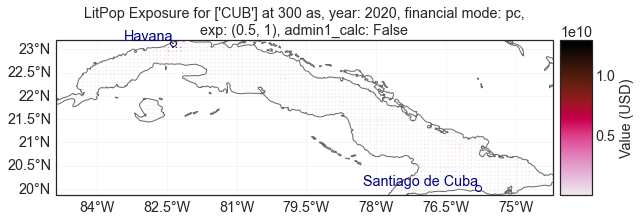

In [36]:
ent_iv.evaluate().exposures.plot_hexbin();

## Entity Future

The following types of uncertainties can be added:
- CO: scale the cost (homogeneously)
            The cost of all measures is multiplied by the same number
            sampled uniformly from a distribution with
            (min, max) = bounds_cost
- EG: scale the exposures growth (homogeneously)
            The value at each exposure point is multiplied by a number
            sampled uniformly from a distribution with
            (min, max) = bounds_eg
- EN: mutliplicative noise (inhomogeneous)
            The value of each exposure point is independently multiplied by
            a random number sampled uniformly from a distribution
            with (min, max) = bounds_noise. EN is the value of the seed
            for  the uniform random number generator.
- EL: sample uniformly from exposure list
            From the provided list of exposure is elements are uniformly
            sampled. For example, LitPop instances with different exponents.
- MDD: scale the mdd (homogeneously)
            The value of mdd at each intensity is multiplied by a number
            sampled uniformly from a distribution with
            (min, max) = bounds_mdd
- PAA: scale the paa (homogeneously)
            The value of paa at each intensity is multiplied by a number
            sampled uniformly from a distribution with
            (min, max) = bounds_paa
- IFi: shift the impact function intensity (homogeneously)
            The value intensity are all summed with a random number
            sampled uniformly from a distribution with
            (min, max) = bounds_impfi


If a bounds is None, this parameter is assumed to have no uncertainty.

### Example: single exposures

In [37]:
from climada.entity import Entity
from climada.util.constants import ENT_DEMO_FUTURE

ent_fut = Entity.from_excel(ENT_DEMO_FUTURE)
ent_fut.exposures.ref_year = 2040
ent_fut.check()

2022-01-10 21:10:57,507 - climada.entity.exposures.base - INFO - category_id not set.
2022-01-10 21:10:57,507 - climada.entity.exposures.base - INFO - geometry not set.
2022-01-10 21:10:57,508 - climada.entity.exposures.base - INFO - region_id not set.
2022-01-10 21:10:57,509 - climada.entity.exposures.base - INFO - centr_ not set.


In [38]:
entfut_iv = InputVar.entfut(
    impf_set = ent_fut.impact_funcs,
    exp_list = [ent_fut.exposures],
    meas_set = ent_fut.measures,
    bounds_cost=[0.6, 1.2],
    bounds_eg=[0.8, 1.5],
    bounds_noise=None,
    bounds_mdd=[0.7, 0.9],
    bounds_paa=[1.3, 2],
    haz_id_dict={'TC': [1]}
    )

### Example: list of exposures 

In [39]:
#Define a generic method to make litpop instances with different exponent pairs.
from climada.entity import LitPop
def generate_litpop_base(impf_id, value_unit, haz, assign_centr_kwargs,
                          choice_mn, **litpop_kwargs):
    #In-function imports needed only for parallel computing on Windows
    from climada.entity import LitPop
    litpop_base = []
    for [m, n] in choice_mn:
        print('\n Computing litpop for m=%d, n=%d \n' %(m, n))
        litpop_kwargs['exponents'] = (m, n)
        exp = LitPop.from_countries(**litpop_kwargs)
        exp.gdf['impf_' + haz.tag.haz_type] = impf_id
        exp.gdf.drop('impf_', axis=1, inplace=True)
        if value_unit is not None:
            exp.value_unit = value_unit
        exp.assign_centroids(haz, **assign_centr_kwargs)
        litpop_base.append(exp)
    return litpop_base

In [40]:
#Define the parameters of the LitPop instances
impf_id = 1
value_unit = None
litpop_kwargs = {
    'countries' : ['CUB'],
    'res_arcsec' : 300, 
    'reference_year' : 2040,
}
assign_centr_kwargs={}

# The hazard is needed to assign centroids
from climada.util.constants import HAZ_DEMO_H5
from climada.hazard import Hazard
haz = Hazard.from_hdf5(HAZ_DEMO_H5)

2022-01-10 21:10:57,529 - climada.hazard.base - INFO - Reading /Users/ckropf/climada/demo/data/tc_fl_1990_2004.h5


In [41]:
#Generate the LitPop list

choice_mn = [[1, 0.5], [0.5, 1], [1, 1]] #Choice of exponents m,n

litpop_list = generate_litpop_base(impf_id, value_unit, haz, assign_centr_kwargs, choice_mn, **litpop_kwargs)



 Computing litpop for m=1, n=0 

2022-01-10 21:10:57,798 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: CUB (192)...

2022-01-10 21:10:57,799 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2040. Using nearest available year for GPW data: 2020
2022-01-10 21:10:57,800 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2022-01-10 21:10:59,239 - climada.util.finance - WARNING - No data available for country. Using non-financial wealth instead
2022-01-10 21:10:59,680 - climada.util.finance - INFO - GDP CUB 2020: 1.074e+11.
2022-01-10 21:10:59,683 - climada.util.finance - WARNING - No data for country, using mean factor.
2022-01-10 21:10:59,693 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2022-01-10 21:10:59,693 - climada.entity.exposures.base - INFO - category_id not set.
2022-01-10 21:10:59,694 - climada.entity.exposures.base - INFO - cover not set.
2022-01-10 21:10:59,6

In [42]:
from climada.entity import Entity
from climada.util.constants import ENT_DEMO_FUTURE

ent_fut = Entity.from_excel(ENT_DEMO_FUTURE)
ent_fut.exposures.ref_year = 2040
ent_fut.check()

2022-01-10 21:11:04,102 - climada.entity.exposures.base - INFO - category_id not set.
2022-01-10 21:11:04,103 - climada.entity.exposures.base - INFO - geometry not set.
2022-01-10 21:11:04,103 - climada.entity.exposures.base - INFO - region_id not set.
2022-01-10 21:11:04,104 - climada.entity.exposures.base - INFO - centr_ not set.


In [43]:
from climada.engine.unsequa import InputVar
entfut_iv = InputVar.entfut(
    impf_set = ent_fut.impact_funcs,
    exp_list = litpop_list,
    meas_set = ent_fut.measures,
    bounds_cost=[0.6, 1.2],
    bounds_eg=[0.8, 1.5],
    bounds_noise=None,
    bounds_mdd=[0.7, 0.9],
    bounds_paa=[1.3, 2],
    haz_id_dict={'TC': [1]}
    )